In [ ]:
# Probably must allow CoLab all access it requests
from google.colab import drive
drive.mount('/content/drive')

# Load all_clean_data.csv into your Drive, and add your path accordingingly
# (Simply comment out other users' specific paths)
DRIVE_PATH = '/content/drive/MyDrive/CIS_583_DL' # Yichen's

Mounted at /content/drive


In [ ]:
pip show keras

Name: keras
Version: 2.15.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: tensorflow


# 1. Imports & Helper Functions

## 1.1 Imports

In [ ]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.utils import to_categorical

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization, Concatenate, Conv1D, Dense, Dropout, Embedding, GlobalMaxPooling1D, LSTM, ReLU, SpatialDropout1D
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
from urllib.parse import urlparse

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## 1.2 Helper Functions

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
# Text Processing
def add_stopwords_missing_apostrophe() -> list:
    stop_words = stopwords.words('english')
    for word in stop_words:
        if "'" in word:
            stop_words.append(re.sub("'", "", word))
    return stop_words


def process_text(text_chunk: str, lemmatizer_obj: WordNetLemmatizer) -> str:
    """Removes everything but alphanumeric characters and stopwords. Lowercases all letters."""
    stop_words = set(add_stopwords_missing_apostrophe())

    try:
        # Replace brackets
        sent = re.sub('[][)(]', ' ', text_chunk)

        # remove URLs
        sent = [word for word in sent.split() if not urlparse(word).scheme]
        sent = ' '.join(sent)

        # remove escape characters
        sent = re.sub(r"\@\w+", " ", sent)

        # remove html tags
        sent = re.sub(re.compile("<.*?>"), ' ', sent)

        # get only characters and numbers from text
        sent = re.sub("[^A-Za-z0-9]", ' ', sent)

        # lowercase all words
        sent = sent.lower()

        # Remove extra whitespace between words
        sent = [word.strip() for word in sent.split()]
        sent = ' '.join(sent)

        # word tokenization
        tokens = word_tokenize(sent)

        # removing words which are in stopwords
        tokens = [t for t in tokens if t not in stop_words]

        # lemmatization
        sent = [lemmatizer_obj.lemmatize(word) for word in tokens]
        sent = ' '.join(sent)
        return sent

    except Exception as ex:
        print(sent,"\n")
        print("Error ",ex)

## 1.3 Shared Parameters

In [ ]:
labels = ['0: No stress', '1: Stressed']

In [ ]:
RANDOM_VALUE = 42
VOCAB_SIZE = 10_000

In [ ]:
BUFFER_SIZE = 5000
BATCH_SIZE = 256
EPOCHS = 50
PATIENCE = 3

In [ ]:
max_len = 50
embedding_dim = 32

# 2. Read and Preprocessing data

## 2.0 Load Cleaned Data

See [GitHub repo](https://github.com/Yichen-Z/cis583_project/blob/main/DeepLearningAlgo.ipynb) for details on combining Kaggle datasets.

In [ ]:
DRIVE_PATH = '/content/drive/MyDrive/CIS_583_DL'

In [ ]:
df = pd.read_csv(f'{DRIVE_PATH}/all_clean_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22632 entries, 0 to 22631
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   label           22632 non-null  int64 
 1   processed_text  22632 non-null  object
dtypes: int64(1), object(1)
memory usage: 353.8+ KB


## 2.1 Explore Data

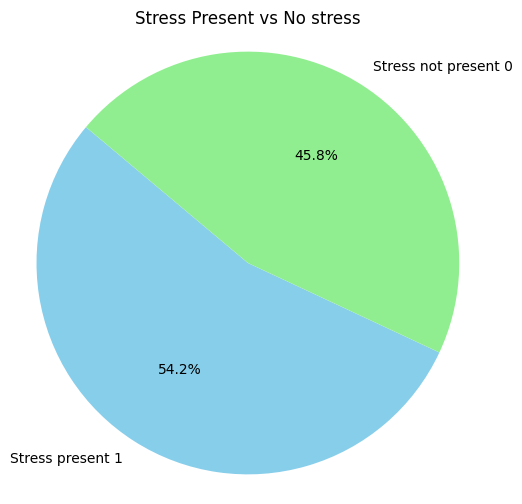

In [ ]:
# Sample binary dataset
sizes=[sum(1 for label in df['label'] if label == 1),sum(1 for label in df['label'] if label == 0)]

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen'])

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
plt.title('Stress Present vs No stress')
plt.show()

## 2.2 Train, Validation, and Test Split

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    df['processed_text'], df['label'],
    test_size=0.3, random_state=RANDOM_VALUE
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5, random_state=RANDOM_VALUE
)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((15842,), (15842,), (3395,), (3395,), (3395,), (3395,))

# 3. ML Models with TF-IDF Embedding

## 3.1 Term Frequency, Inverse-Document Frequency Embedding

Performs comparably to simple word count. Chosen over word count embedding due to smaller vector values.

No tokens appeared more often than across 60% of the texts, so a threshold was applied to keep this embedding comparable with the DL learned embeddings with vocabulary size of 10K.

In [ ]:
td_vectorizer = TfidfVectorizer(
    max_features=VOCAB_SIZE
)
X_train_tfidf = td_vectorizer.fit_transform(X_train)
len(td_vectorizer.vocabulary_)

10000

In [ ]:
# Use vectorizer built on training set for the validation and test sets
X_val_tfidf = td_vectorizer.transform(X_val)
X_test_tfidf = td_vectorizer.transform(X_test)
X_val_tfidf.shape, X_test_tfidf.shape

((3395, 10000), (3395, 10000))

## 3.2 ML Models

### 3.2.1 Logistic Regression Model

In [ ]:
logreg = LogisticRegression().fit(X_train_tfidf, y_train)

In [ ]:
logreg_preds = logreg.predict(X_test_tfidf)

Normalized confusion matrix


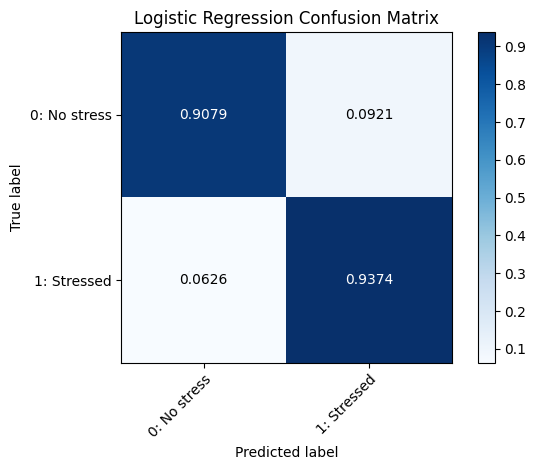

In [ ]:
plot_confusion_matrix(y_test, logreg_preds, labels, normalize=True,
                          title='Logistic Regression Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(logreg_preds, y_test))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1543
           1       0.94      0.92      0.93      1852

    accuracy                           0.92      3395
   macro avg       0.92      0.92      0.92      3395
weighted avg       0.92      0.92      0.92      3395



### 3.2.2 Naive Bayes Classification Model

In [ ]:
bayes = MultinomialNB().fit(X_train_tfidf, y_train)

Normalized confusion matrix


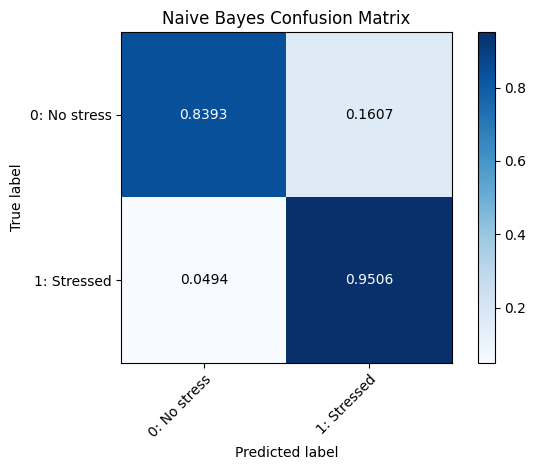

In [ ]:
bayes_preds = bayes.predict(X_test_tfidf)
plot_confusion_matrix(y_test, bayes_preds, labels, normalize=True,
                          title='Naive Bayes Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(bayes_preds, y_test))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      1411
           1       0.95      0.87      0.91      1984

    accuracy                           0.90      3395
   macro avg       0.89      0.90      0.90      3395
weighted avg       0.90      0.90      0.90      3395



### 3.2.3 Random Forest Model

In [ ]:
rf = RandomForestClassifier().fit(X_train_tfidf, y_train)

Normalized confusion matrix


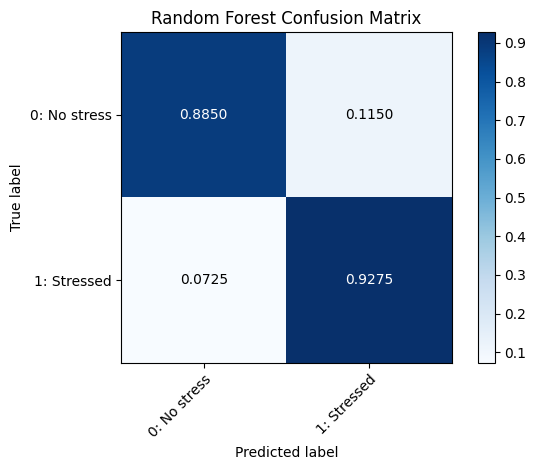

In [ ]:
rf_preds = rf.predict(X_test_tfidf)
plot_confusion_matrix(
    y_test, rf_preds, labels, normalize=True,
    title='Random Forest Confusion Matrix'
)
plt.show()

In [ ]:
print(classification_report(rf_preds, y_test))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1525
           1       0.93      0.90      0.92      1870

    accuracy                           0.91      3395
   macro avg       0.91      0.91      0.91      3395
weighted avg       0.91      0.91      0.91      3395



# 4. DL Models with Learned Embeddings

## 4.1 CNN & LSTM Embedding

In [ ]:
encoder = LabelEncoder()
cnn_y_train = encoder.fit_transform(y_train)
cnn_val_label = encoder.transform(y_val)
cnn_test_label = encoder.transform(y_test)

In [ ]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)

In [ ]:
sequences = tokenizer.texts_to_sequences(X_train)
tr_x = pad_sequences(sequences, maxlen=max_len)
tr_y = to_categorical(cnn_y_train)

sequences = tokenizer.texts_to_sequences(X_val)
val_x = pad_sequences(sequences, maxlen=max_len)
val_y = to_categorical(cnn_val_label)

sequences = tokenizer.texts_to_sequences(X_test)
ts_x = pad_sequences(sequences, maxlen=max_len)
ts_y = to_categorical(cnn_test_label)

## 4.2 RNN Embeddings

In [ ]:
text_vect = tf.keras.layers.TextVectorization(
    output_mode='int',
    max_tokens=VOCAB_SIZE,
)

# Train the vectorizer
text_vect.adapt(X_train)

In [ ]:
X_train_default = text_vect(X_train)
X_val_default = text_vect(X_val)
X_test_default = text_vect(X_test)

## 4.3 DL Models

### 4.3.1 CNN

In [ ]:
# Branch 1
branch1 = Sequential()
branch1.add(Embedding(VOCAB_SIZE, embedding_dim, input_length=max_len))
branch1.add(Conv1D(64, 3, padding='same', activation='relu'))
branch1.add(BatchNormalization())
branch1.add(ReLU())
branch1.add(Dropout(0.5))
branch1.add(GlobalMaxPooling1D())

# Branch 2
branch2 = Sequential()
branch2.add(Embedding(VOCAB_SIZE, embedding_dim, input_length=max_len))
branch2.add(Conv1D(64, 3, padding='same', activation='relu'))
branch2.add(BatchNormalization())
branch2.add(ReLU())
branch2.add(Dropout(0.5))
branch2.add(GlobalMaxPooling1D())

concatenated = Concatenate()([branch1.output, branch2.output])

hid_layer = Dense(128, activation='relu')(concatenated)
dropout = Dropout(0.3)(hid_layer)
output_layer = Dense(2, activation='softmax')(dropout)

model = Model(inputs=[branch1.inputs, branch2.inputs], outputs=output_layer)

In [ ]:
model.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embedding_4_input (InputLa  [(None, 50)]                 0         []                            
 yer)                                                                                             
                                                                                                  
 embedding_5_input (InputLa  [(None, 50)]                 0         []                            
 yer)                                                                                             
                                                                                                  
 embedding_4 (Embedding)     (None, 50, 32)               320000    ['embedding_4_input[0][0]']   
                                                                                            

In [ ]:
history = model.fit([tr_x, tr_x], tr_y, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=([val_x, val_x], val_y))

(loss, accuracy, percision, recall) = model.evaluate([ts_x, ts_x], ts_y)

print(f'Loss: {round(loss, 2)}, Accuracy: {round(accuracy, 2)}, Precision: {round(percision, 2)}, Recall: {round(recall, 2)}')

Epoch 1/50
62/62 [==============================] - 5s 77ms/step - loss: 0.5781 - accuracy: 0.6900 - precision_1: 0.6900 - recall_1: 0.6900 - val_loss: 0.6742 - val_accuracy: 0.6510 - val_precision_1: 0.6510 - val_recall_1: 0.6510
Epoch 2/50
62/62 [==============================] - 5s 82ms/step - loss: 0.4277 - accuracy: 0.8027 - precision_1: 0.8027 - recall_1: 0.8027 - val_loss: 0.6330 - val_accuracy: 0.8218 - val_precision_1: 0.8218 - val_recall_1: 0.8218
Epoch 3/50
62/62 [==============================] - 6s 103ms/step - loss: 0.2853 - accuracy: 0.8812 - precision_1: 0.8812 - recall_1: 0.8812 - val_loss: 0.5627 - val_accuracy: 0.8792 - val_precision_1: 0.8792 - val_recall_1: 0.8792
Epoch 4/50
62/62 [==============================] - 5s 74ms/step - loss: 0.2040 - accuracy: 0.9181 - precision_1: 0.9181 - recall_1: 0.9181 - val_loss: 0.4794 - val_accuracy: 0.9052 - val_precision_1: 0.9052 - val_recall_1: 0.9052
Epoch 5/50
62/62 [==============================] - 5s 78ms/step - loss: 0.

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1'])

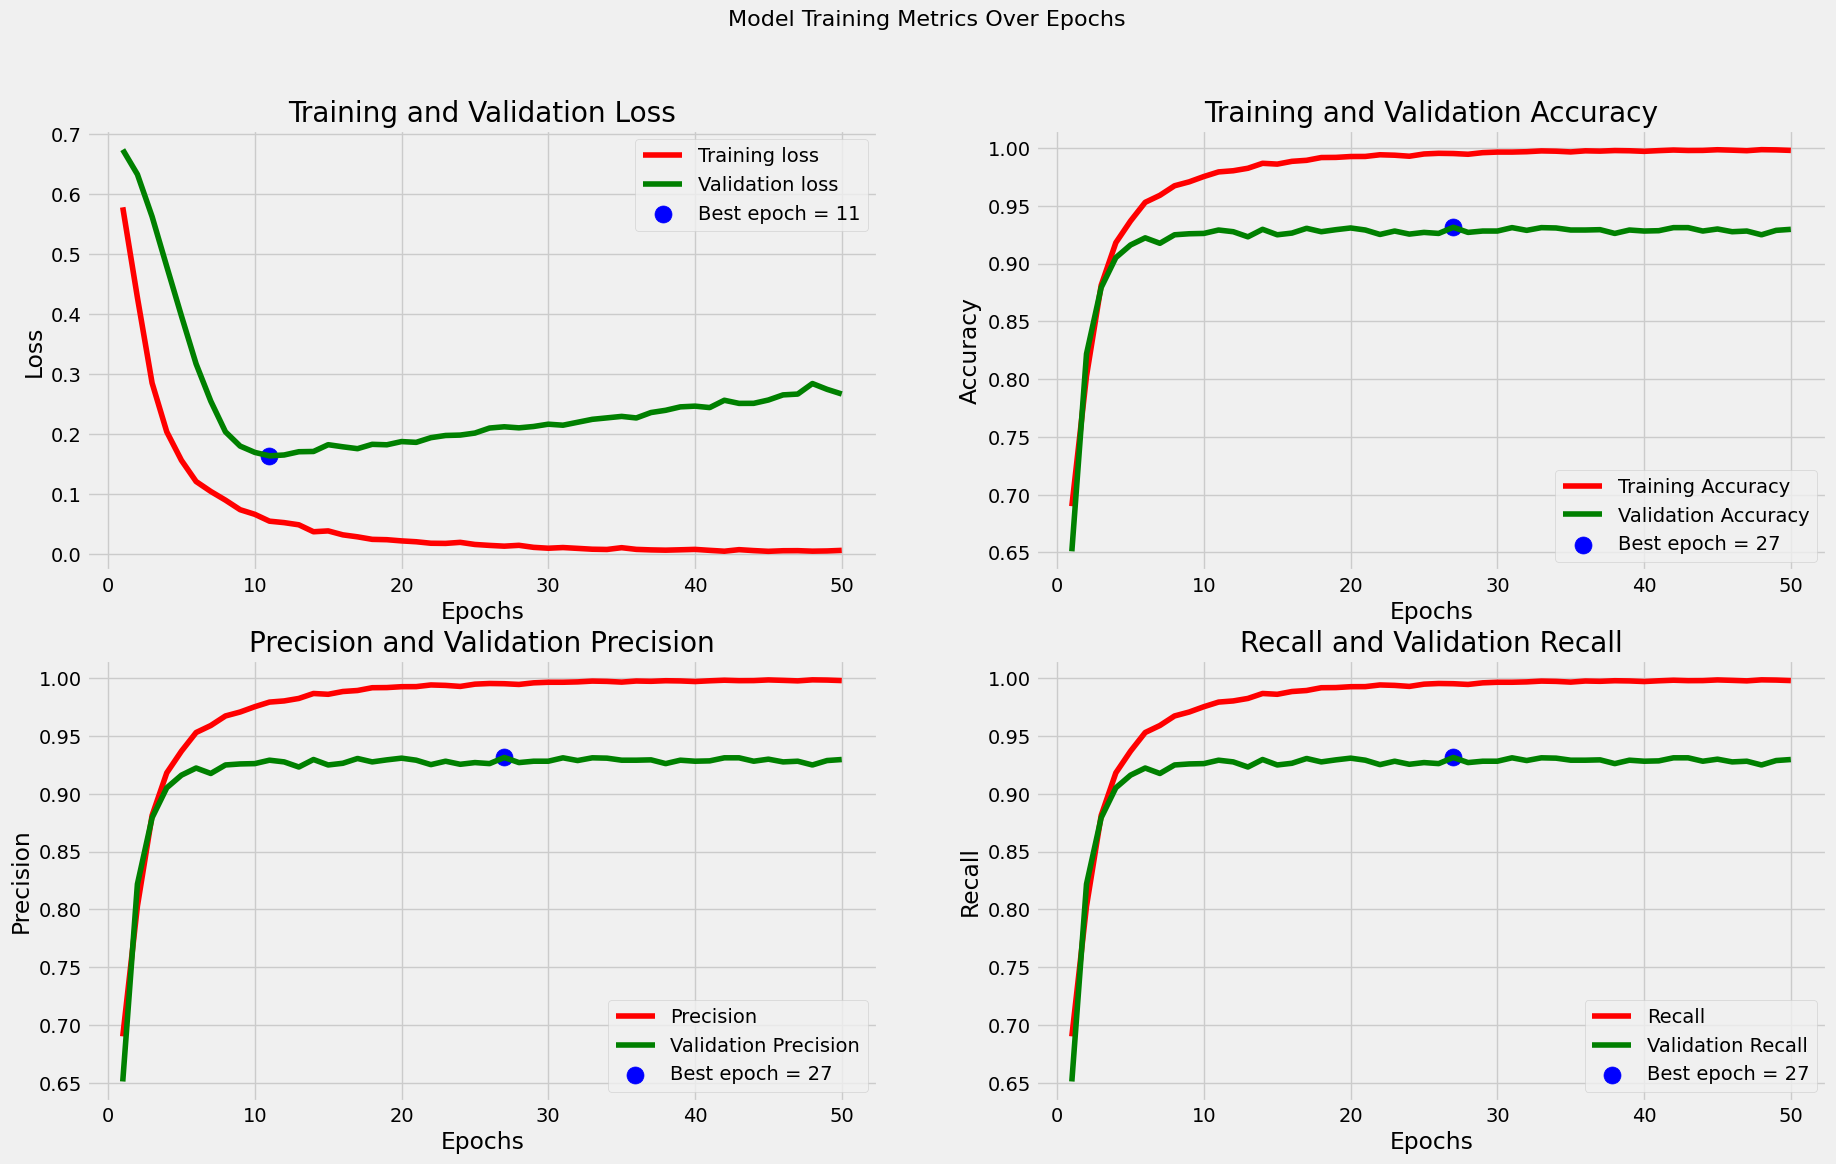

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
tr_per = history.history['precision_1']
tr_recall = history.history['recall_1']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_per = history.history['val_precision_1']
val_recall = history.history['val_recall_1']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]


Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [ ]:
with open(f'{DRIVE_PATH}/tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

model.save(f'{DRIVE_PATH}/cnn.h5')

### 4.3.2 RNN

In [ ]:
inputs = tf.keras.Input(shape=(None,), dtype='int64')
embedded = layers.Embedding(
    input_dim=X_train_default.shape[0], output_dim=256, mask_zero=True
)(inputs)

# Bidirectional LSTM
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)

# Classification layer
outputs = layers.Dense(1, activation='sigmoid')(x)

rnn_model = tf.keras.Model(inputs, outputs)

In [ ]:
rnn_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
rnn_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 256)         4055552   
                                                                 
 bidirectional (Bidirection  (None, 64)                73984     
 al)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4129601 (15.75 MB)
Trainable params: 4129601 (15.75 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [ ]:
rnn_early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=PATIENCE
)
rnn_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    f'{DRIVE_PATH}/rnn.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min'
)

In [ ]:
rnn_history = rnn_model.fit(
    X_train_default, y_train, validation_data=(X_val_default, y_val),
    batch_size=BATCH_SIZE, epochs=EPOCHS,
    callbacks=[rnn_early_stop_callback, rnn_checkpoint_callback]
)

Epoch 1/50
62/62 [==============================] - ETA: 0s - loss: 0.6834 - accuracy: 0.5490
Epoch 1: val_loss improved from inf to 0.66181, saving model to rnn.keras
62/62 [==============================] - 69s 973ms/step - loss: 0.6834 - accuracy: 0.5490 - val_loss: 0.6618 - val_accuracy: 0.6074
Epoch 2/50
62/62 [==============================] - ETA: 0s - loss: 0.5312 - accuracy: 0.7812
Epoch 2: val_loss improved from 0.66181 to 0.37416, saving model to rnn.keras
62/62 [==============================] - 55s 880ms/step - loss: 0.5312 - accuracy: 0.7812 - val_loss: 0.3742 - val_accuracy: 0.8922
Epoch 3/50
62/62 [==============================] - ETA: 0s - loss: 0.2564 - accuracy: 0.9268
Epoch 3: val_loss improved from 0.37416 to 0.23679, saving model to rnn.keras
62/62 [==============================] - 54s 861ms/step - loss: 0.2564 - accuracy: 0.9268 - val_loss: 0.2368 - val_accuracy: 0.9140
Epoch 4/50
62/62 [==============================] - ETA: 0s - loss: 0.1555 - accuracy: 0.949

### 4.3.3 LSTM

In [ ]:
lstm_model = Sequential(
    [
        Embedding(input_dim=VOCAB_SIZE, output_dim=embedding_dim, input_length=max_len),
        SpatialDropout1D(0.2),
        LSTM(64, dropout=0.2), # Note: If running on GPU and encountering issues, may need to remove 'recurrent_dropout'
        Dense(2, activation='softmax')
    ]
)
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 50, 32)            320000    
                                                                 
 spatial_dropout1d_1 (Spati  (None, 50, 32)            0         
 alDropout1D)                                                    
                                                                 
 lstm_2 (LSTM)               (None, 64)                24832     
                                                                 
 dense_6 (Dense)             (None, 2)                 130       
                                                                 
Total params: 344962 (1.32 MB)
Trainable params: 344962 (1.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
lstm_early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=PATIENCE
)
lstm_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    f'{DRIVE_PATH}/lstm_checkpoint.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min'
)

In [ ]:
lstm_history = lstm_model.fit(
    tr_x, tr_y, validation_data=(val_x, val_y),
    batch_size=BATCH_SIZE, epochs=EPOCHS,
    callbacks=[lstm_early_stop_callback, lstm_checkpoint_callback]
)

Epoch 1/50
62/62 [==============================] - ETA: 0s - loss: 0.6593 - accuracy: 0.6020
Epoch 1: val_loss improved from inf to 0.56392, saving model to /content/drive/MyDrive/CIS_583_DL/lstm_checkpoint.h5
62/62 [==============================] - 12s 158ms/step - loss: 0.6593 - accuracy: 0.6020 - val_loss: 0.5639 - val_accuracy: 0.8368
Epoch 2/50
62/62 [==============================] - ETA: 0s - loss: 0.3631 - accuracy: 0.8756
Epoch 2: val_loss improved from 0.56392 to 0.27449, saving model to /content/drive/MyDrive/CIS_583_DL/lstm_checkpoint.h5
62/62 [==============================] - 7s 119ms/step - loss: 0.3631 - accuracy: 0.8756 - val_loss: 0.2745 - val_accuracy: 0.9063
Epoch 3/50
62/62 [==============================] - ETA: 0s - loss: 0.1691 - accuracy: 0.9398
Epoch 3: val_loss improved from 0.27449 to 0.24587, saving model to /content/drive/MyDrive/CIS_583_DL/lstm_checkpoint.h5
62/62 [==============================] - 9s 142ms/step - loss: 0.1691 - accuracy: 0.9398 - val_l

# 5. DL Confusion Matrices

## 5.1 CNN Confusion Matrix

In [ ]:
x=model.predict([ts_x,ts_x])
y_predict=np.round(x)
y_true=ts_y[:,0]
y_predict=y_predict[:,0]

107/107 [==============================] - 1s 9ms/step


Normalized confusion matrix


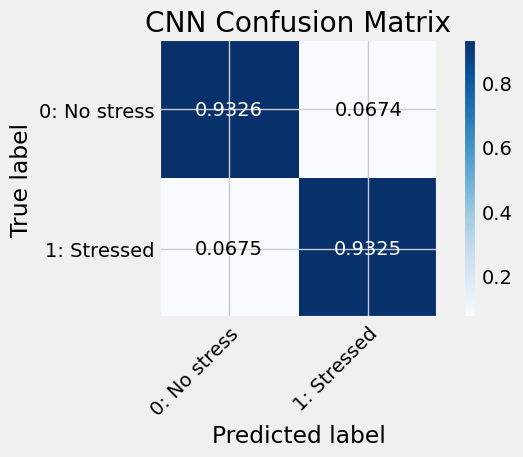

In [ ]:
plot_confusion_matrix(y_predict, y_true, labels, normalize=True, title='CNN Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_predict, y_true))

              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94      1840
         1.0       0.92      0.93      0.93      1555

    accuracy                           0.93      3395
   macro avg       0.93      0.93      0.93      3395
weighted avg       0.93      0.93      0.93      3395



## 5.2 RNN Confusion Matrix

In [ ]:
rnn_pred = rnn_model.predict(X_test_default).round()

107/107 [==============================] - 7s 42ms/step


Normalized confusion matrix


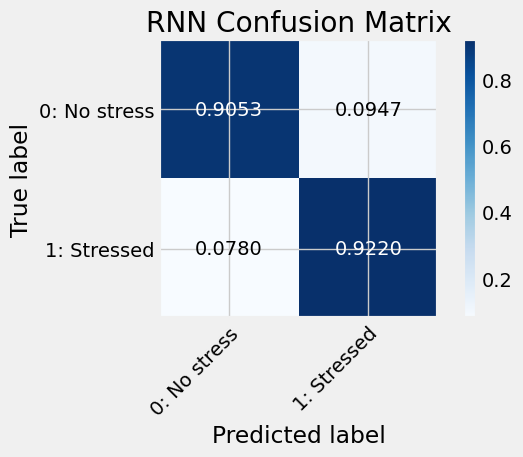

In [ ]:
rnn_ax = plot_confusion_matrix(y_true=y_test, y_pred=rnn_pred, classes=labels,
                                     normalize=True,
                                     title='RNN Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(rnn_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91      1567
         1.0       0.92      0.92      0.92      1828

    accuracy                           0.91      3395
   macro avg       0.91      0.91      0.91      3395
weighted avg       0.91      0.91      0.91      3395



## 5.3 LSTM Confusion Matrix

107/107 [==============================] - 2s 11ms/step
Normalized confusion matrix


<Axes: title={'center': 'LSTM Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

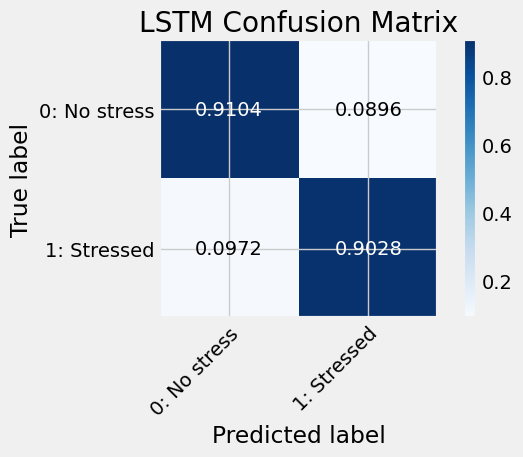

In [ ]:
true_classes = np.argmax(ts_y, axis=1)  # Assuming ts_y is one-hot encoded
ts_predictions = lstm_model.predict(ts_x)
predicted_classes_test = np.argmax(ts_predictions, axis=1)
plot_confusion_matrix(true_classes, predicted_classes_test, labels, normalize=True, title='LSTM Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(true_classes, predicted_classes_test))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1574
           1       0.92      0.90      0.91      1821

    accuracy                           0.91      3395
   macro avg       0.91      0.91      0.91      3395
weighted avg       0.91      0.91      0.91      3395



# 6. One-off Predictions

In [ ]:
from tensorflow.keras.models import load_model

def load_tokenizer(tokenizer_path: str):
    tokenizer = None
    with open(tokenizer_path, 'rb') as f:
        tokenizer = pickle.load(f)
    return tokenizer


def ml_predict_stress(text, model, vectorizer):
    output = 'Stress NOT detected'

    processed = process_text(text, WordNetLemmatizer())
    embedding = vectorizer.transform([processed])
    result = model.predict(embedding)
    if result[0] == 1:
        output = 'STRESS detected'

    return output


def cnn_predict_stress(text, model, tokenizer):
    sequences = tokenizer.texts_to_sequences([text])
    x_new = pad_sequences(sequences, maxlen=50)
    predictions = model.predict([x_new, x_new])

    outcomes = {0: 'No stress', 1: 'Stressed'}

    label = list(outcomes.values())
    probs = list(predictions[0])
    plt.subplot(1, 1, 1)
    bars = plt.barh(label, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()


def lstm_predict_stress(text, model, tokenizer):
    sequences = tokenizer.texts_to_sequences([text])
    x_new = pad_sequences(sequences, maxlen=50)
    predictions = model.predict(x_new)

    outcomes = {0: 'No stress', 1: 'Stressed'}

    label = list(outcomes.values())
    probs = list(predictions[0])
    plt.subplot(1, 1, 1)
    bars = plt.barh(label, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

In [ ]:
def rnn_predict_stress(text, model, tokenizer, threshold=0.5):
    output = 'Stress NOT detected'

    processed = process_text(text, WordNetLemmatizer())
    embedding = tokenizer(processed)
    embedding = np.expand_dims(embedding, axis=0)
    result = model.predict(embedding)
    if result > threshold:
      output = 'STRESS detected'
    print(result)
    return output

In [ ]:
happy_text = 'I am very happy to finish this project'
sad_text = 'I am very sad'
worry_text = 'Taxes are due soon. I am so worried I will not be able to complete them on time.'
neutral_text = 'The sky is blue'
angry_text = "I can't believe they canceled my flight! I am never using this airline again!!"

## 6.1 Logistic Regression

In [ ]:
ml_predict_stress(happy_text, logreg, td_vectorizer)

'Stress NOT detected'

In [ ]:
ml_predict_stress(sad_text, logreg, td_vectorizer)

'STRESS detected'

In [ ]:
ml_predict_stress(worry_text, logreg, td_vectorizer)

'STRESS detected'

In [ ]:
ml_predict_stress(neutral_text, logreg, td_vectorizer)

'STRESS detected'

In [ ]:
ml_predict_stress(angry_text, logreg, td_vectorizer)

'STRESS detected'

## 6.2 Naive Bayes

In [ ]:
ml_predict_stress(happy_text, bayes, td_vectorizer)

'Stress NOT detected'

In [ ]:
ml_predict_stress(sad_text, bayes, td_vectorizer)

'STRESS detected'

In [ ]:
ml_predict_stress(worry_text, bayes, td_vectorizer)

'STRESS detected'

In [ ]:
ml_predict_stress(neutral_text, bayes, td_vectorizer)

'STRESS detected'

In [ ]:
ml_predict_stress(angry_text, bayes, td_vectorizer)

'STRESS detected'

## 6.3 Random Forest

In [ ]:
ml_predict_stress(happy_text, rf, td_vectorizer)

'Stress NOT detected'

In [ ]:
ml_predict_stress(sad_text, rf, td_vectorizer)

'STRESS detected'

In [ ]:
ml_predict_stress(worry_text, rf, td_vectorizer)

'STRESS detected'

In [ ]:
ml_predict_stress(neutral_text, rf, td_vectorizer)

'STRESS detected'

In [ ]:
ml_predict_stress(angry_text, rf, td_vectorizer)

'STRESS detected'

## 6.4 CNN

In [ ]:
cnn_lstm_vec = load_tokenizer(f'{DRIVE_PATH}/tokenizer.pkl')

In [ ]:
cnn_model = load_model(f'{DRIVE_PATH}/cnn.h5')
cnn_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embedding_4_input (InputLa  [(None, 50)]                 0         []                            
 yer)                                                                                             
                                                                                                  
 embedding_5_input (InputLa  [(None, 50)]                 0         []                            
 yer)                                                                                             
                                                                                                  
 embedding_4 (Embedding)     (None, 50, 32)               320000    ['embedding_4_input[0][0]']   
                                                                                            

1/1 [==============================] - 1s 503ms/step


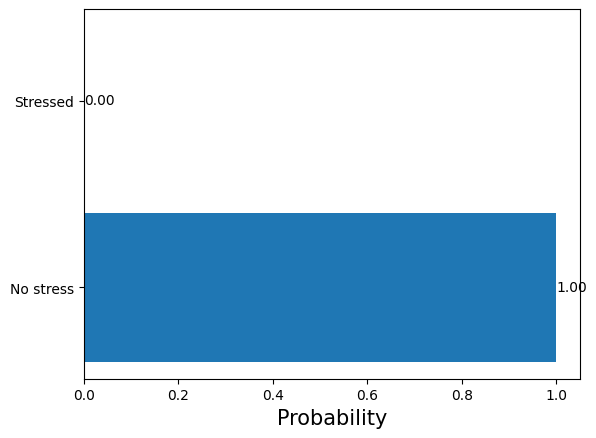

In [ ]:
cnn_predict_stress(happy_text, cnn_model, cnn_lstm_vec)

1/1 [==============================] - 0s 54ms/step


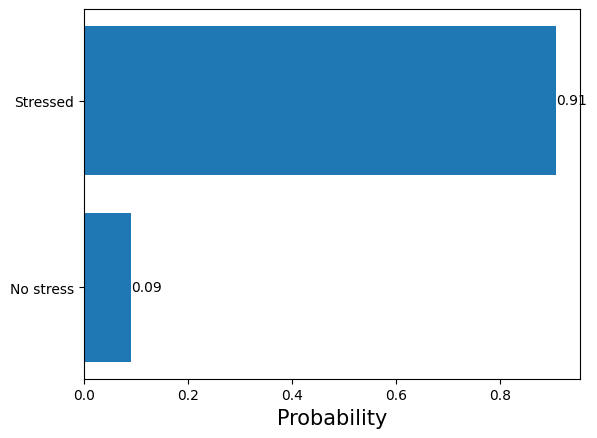

In [ ]:
cnn_predict_stress(sad_text, cnn_model, cnn_lstm_vec)

1/1 [==============================] - 0s 156ms/step


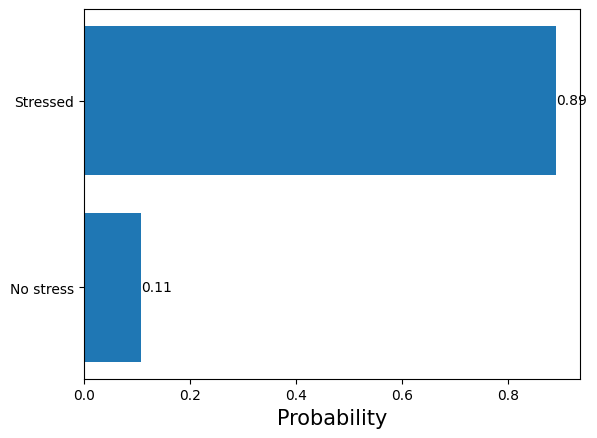

In [ ]:
cnn_predict_stress(worry_text, cnn_model, cnn_lstm_vec)

1/1 [==============================] - 0s 33ms/step


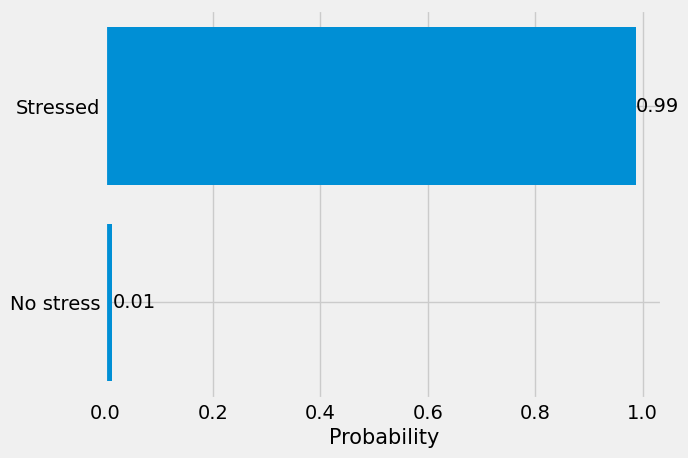

In [ ]:
cnn_predict_stress(angry_text, cnn_model, cnn_lstm_vec)

1/1 [==============================] - 0s 36ms/step


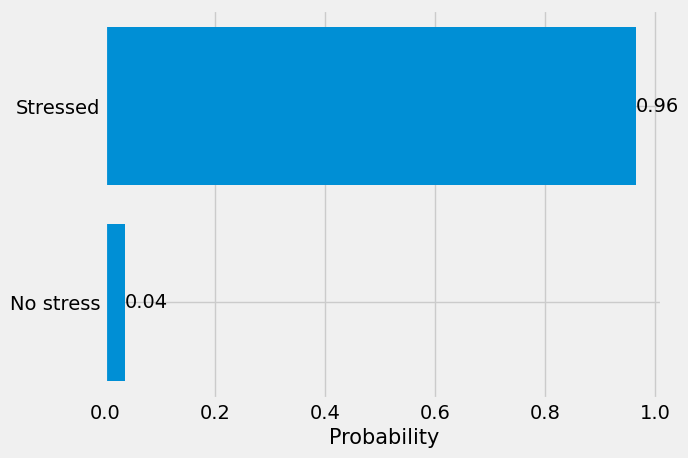

In [ ]:
cnn_predict_stress(neutral_text, cnn_model, cnn_lstm_vec)

## 6.5 RNN

In [ ]:
rnn_model = load_model(f'{DRIVE_PATH}/rnn.h5')

In [ ]:
rnn_predict_stress(happy_text, rnn_model, text_vect)

1/1 [==============================] - 4s 4s/step
[[0.01312109]]


'Stress NOT detected'

In [ ]:
rnn_predict_stress(sad_text, rnn_model, text_vect)

1/1 [==============================] - 0s 29ms/step
[[0.8590371]]


'STRESS detected'

In [ ]:
rnn_predict_stress(worry_text, rnn_model, text_vect)

1/1 [==============================] - 0s 33ms/step
[[0.9360761]]


'STRESS detected'

In [ ]:
rnn_predict_stress(neutral_text, rnn_model, text_vect)

1/1 [==============================] - 0s 37ms/step
[[0.77547055]]


'STRESS detected'

In [ ]:
rnn_predict_stress(angry_text, rnn_model, text_vect)

1/1 [==============================] - 0s 28ms/step
[[0.95781416]]


'STRESS detected'

## 6.6 LSTM

In [ ]:
lstm_model = load_model(f'{DRIVE_PATH}/lstm_checkpoint.h5')

1/1 [==============================] - 1s 1s/step


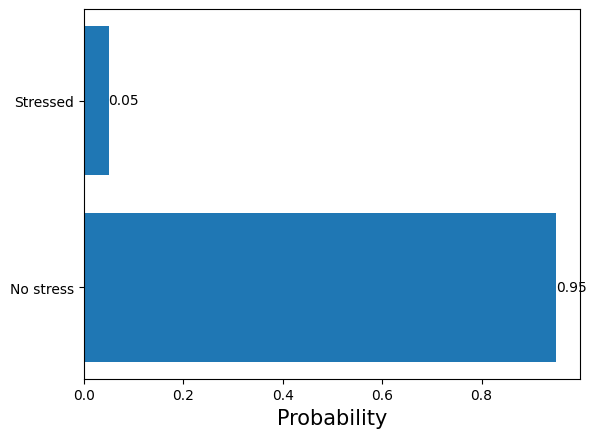

In [ ]:
lstm_predict_stress(happy_text, lstm_model, cnn_lstm_vec)

1/1 [==============================] - 0s 110ms/step


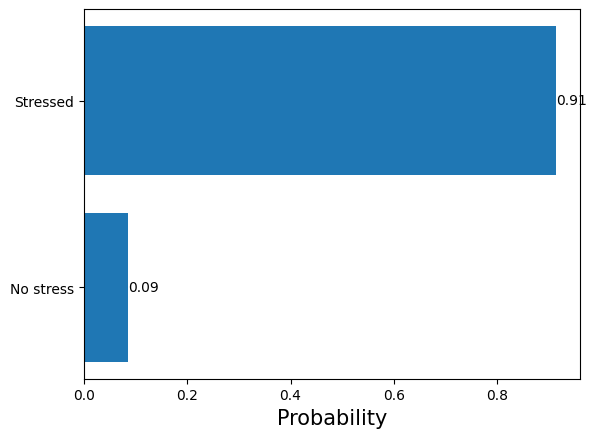

In [ ]:
lstm_predict_stress(sad_text, lstm_model, cnn_lstm_vec)

1/1 [==============================] - 0s 43ms/step


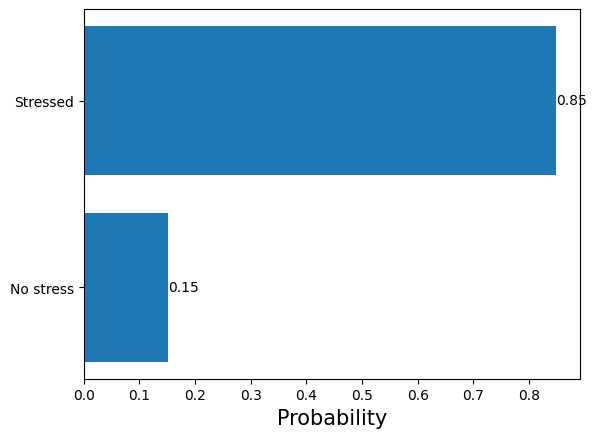

In [ ]:
lstm_predict_stress(worry_text, lstm_model, cnn_lstm_vec)

1/1 [==============================] - 0s 52ms/step


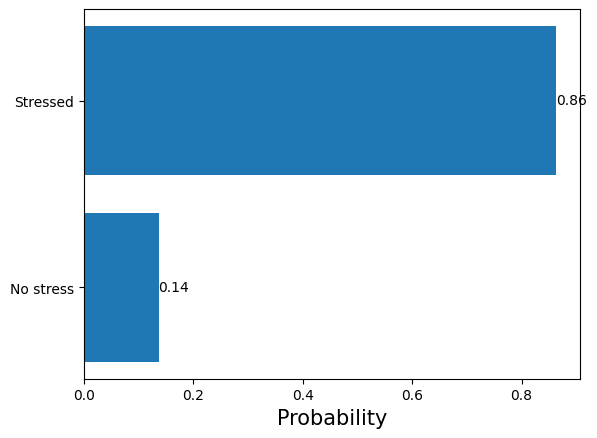

In [ ]:
lstm_predict_stress(neutral_text, lstm_model, cnn_lstm_vec)

1/1 [==============================] - 0s 108ms/step


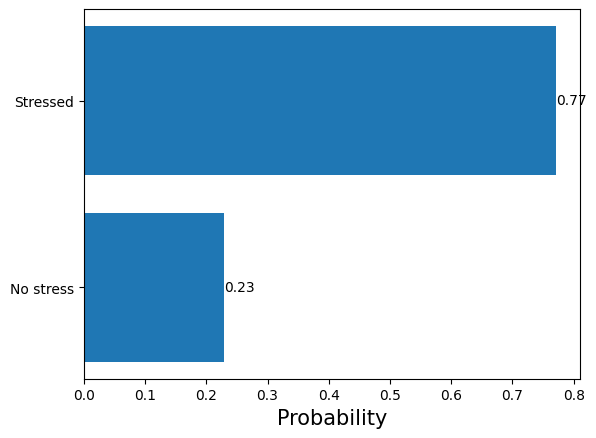

In [ ]:
lstm_predict_stress(angry_text, lstm_model, cnn_lstm_vec)